
# Clouds Step By Step

Reconstruct and event with clouds, step by step.

Didactic and debugin purposes.

#### JA Hernando, April 2021

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import matplotlib.pyplot as plt

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

import clouds.ridges    as ridges

In [3]:
plt.rcParams['image.cmap'] = 'Blues'

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Wed May  5 19:56:19 2021


## Generate an event


Generate points along a line with a given dispersion in (x, y)

## Generate sample

In [4]:
def canvas(nx = 1, ny = 1, xsize = 4., ysize = 5):
    plt.figure(figsize = (ny * ysize, nx * xsize))
    subplot = lambda i : plt.subplot(nx, ny, i)
    return subplot

In [139]:
def generate_points(sizes, line = None, sigma = 1):
    
    size0   = np.min(sizes)
    npoints = len(sizes)
    ts = np.linspace(0, 1., npoints)
    ts = [ni * [ti,] for ni, ti in zip(sizes, ts)]
    ts.append(np.random.uniform(size = size0))
    ts = np.concatenate(ts)

    size = len(ts)
    iden = lambda x: x
    x, y = (iden, iden) if line is None else line
    xs   = x(ts) + sigma * np.random.normal(size = size)
    ys   = y(ts) + sigma * np.random.normal(size = size)
    
    return xs, ys

In [164]:
sizes = 1000 * np.array((3, 3, 3, 3, 3, 3))
scale, offset = 5, 2
line  = lambda x: scale * x,  lambda x: offset + scale * x
xs, ys = generate_points(sizes, line, sigma = 0.5)

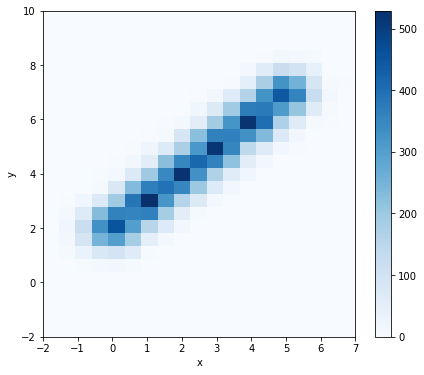

In [165]:
size  = 2
xbins = np.linspace(-2,  7, size * 10)
ybins = np.linspace(-2, 10, size * 13)

bins          = (xbins, ybins)
counts, _, _  = np.histogram2d(xs, ys, bins = bins)

subplot = canvas(1, 1, 6, 7)
subplot(1)
plt.hist2d(xs, ys, bins);
#plt.imshow(counts.T, origin = 'lower')
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();

## Clouds input

   * Input data are:
       
       * coors   : a list of coordinates of the points: (x, y)
       
       * steps   : a list with the steps in each dimention (x-step, y-step)
       
       * weights : the weigths or energy of each point (ene)

In [166]:
coors   = (xs, ys)
steps   = (xbins[1] - xbins[0], ybins[1] - ybins[0])
weights = np.ones(len(xs))

## 1 Clouds - Execute


In [167]:
bins, mask, cells, df = clouds.clouds(coors, steps, weights)

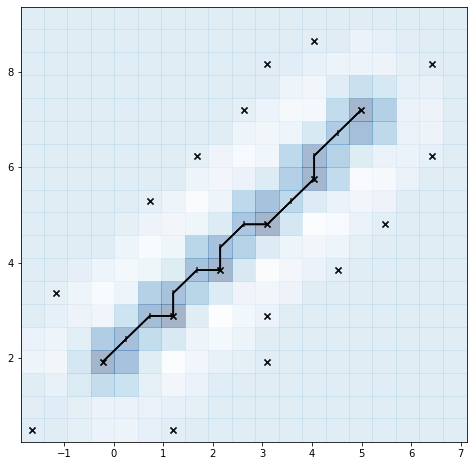

In [168]:
plt.figure(figsize = (8, 8));
draw = pltclouds.drawer(cells, bins, df, 'p')
draw(ispass = True);

### Compute curvature 


In [169]:
counts, _ = np.histogramdd(cells, bins = bins, weights = df.evalue)
hess      = ridges.hessian(counts)
uu        = np.array((0, 1))
vv        = ridges.hess2d_v(hess, uu)

np.sum(vv == hess[1, 1])

361

### The minimum of the eigen-values

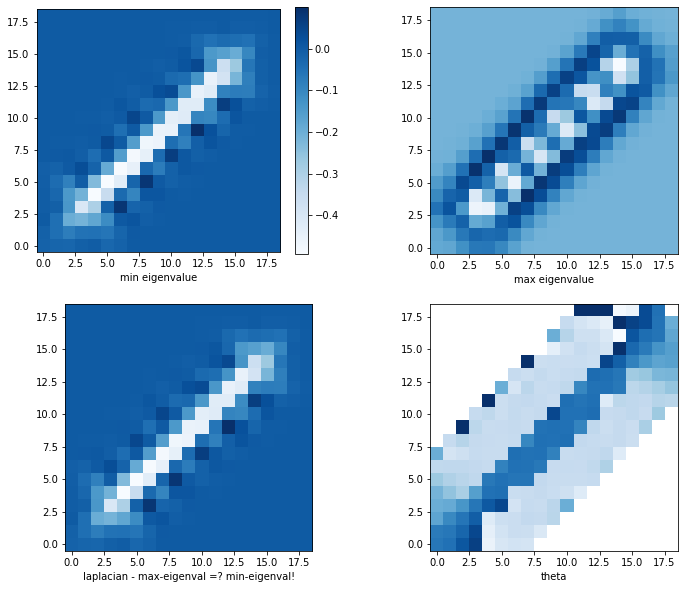

In [170]:
lap           = ridges.laplacian(hess)
l1, l2, theta = ridges.hess2d_eigvals(hess) 
lmin, lmax = np.minimum(l1, l2), np.maximum(l1, l2)

plt.figure(figsize = (2 * 6, 2 * 5))

plt.subplot(2, 2, 1)
plt.imshow(lmin.T, origin = 'lower');
plt.colorbar();
plt.xlabel('min eigenvalue')

plt.subplot(2, 2, 2)
plt.imshow(lmax.T, origin = 'lower');
plt.xlabel('max eigenvalue')

plt.subplot(2, 2, 3)
plt.imshow(lap.T - lmax.T, origin = 'lower');
plt.xlabel('laplacian - max-eigenval =? min-eigenval!')

plt.subplot(2, 2, 4)
plt.imshow(theta.T, origin = 'lower');
plt.xlabel('theta');

167 167 167


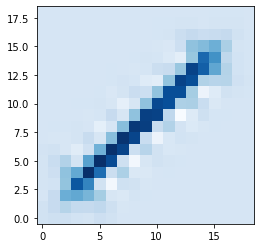

In [171]:
vv  = -lmin + np.max(lmin)
size = len(df.evalue)
plt.imshow(vv.T, origin = 'lower');
condition = np.full(size, True, bool)
vals = vv[mask]
print(len(vals), size, np.sum(vals >= 0))
dat = clouds._clouds(bins, mask, cells, vals, condition)

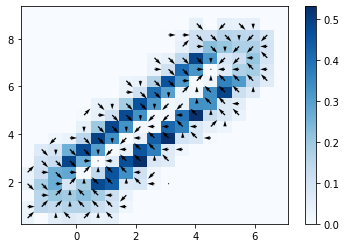

In [174]:
egrad = dat[0]
epath = dat[1]
plt.hist2d(*cells, bins, weights = egrad);
plt.colorbar();
pltclouds.draw_grad(cells, epath);

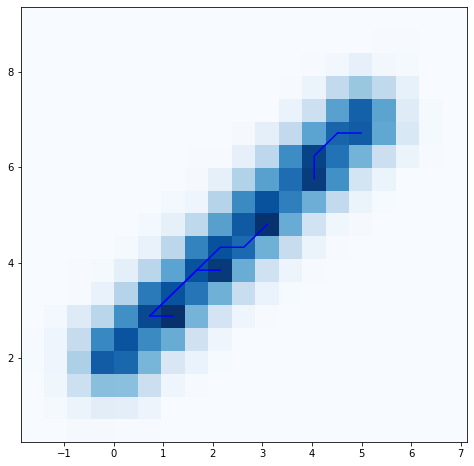

In [175]:
elmin = lmin[mask]
kids  = np.argwhere((df.eisnode.values) & (df.pvalue.values< 0))
paths    = [clouds.get_path(kid, epath) for kid in kids]
segments = [clouds.get_segment(cells, path) for path in paths] 

plt.figure(figsize = (8, 8))
plt.hist2d(*cells, bins, weights =  df.evalue.values);
for segment in segments:
    plt.plot(*segment, color = 'b');

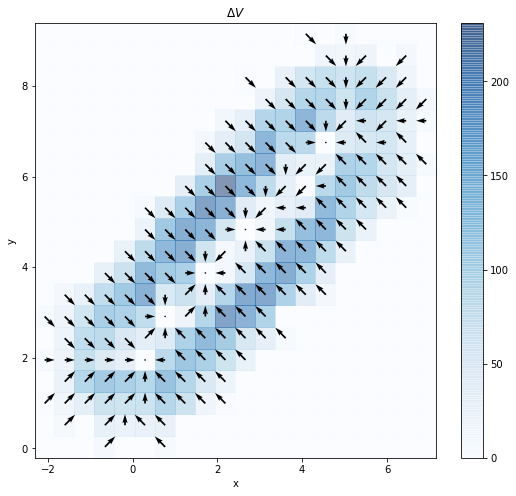

In [13]:
canvas(1, 1, 8, 9)
plt.hist2d(*cells, bins = bins, weights = egrad, alpha = 0.5)
plt.colorbar();
pltclouds.draw_grad(cells, epath)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'$\Delta V$');
#plt.plot((0, 5), (2, 7), color = 'red',ls = '--');

### Compute the nodes

   * *isnode*: True/False if this cell is a node
   
   * *node*: the ID of the cells that is the node to wich each cells belongs
   

In [14]:
isnode = clouds.find_nodes(egrad)
node   = clouds.set_node(epath)
cells_selection = clouds.cells_selection

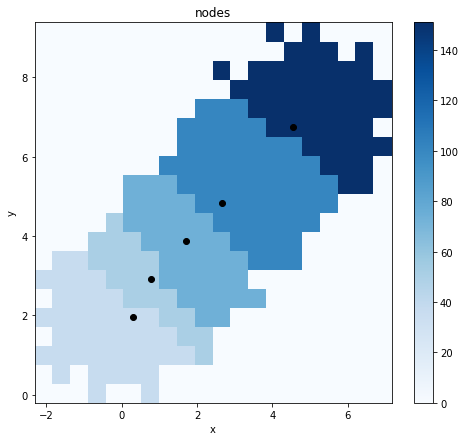

In [15]:
canvas(1, 1, 7, 8)

plt.hist2d(*cells, bins = bins, weights = node)
plt.colorbar();
plt.plot(*cells_selection(cells, isnode), marker = 'o', ls = '', color = 'black');
plt.xlabel('x'); plt.ylabel('y'); plt.title('nodes');

### Path of each cell to its node

  One can reach the node from any cell via two helper functions:
  
  *get_path*    : returns the list of the cells from a given one to the node,
  *get_segment* : converts the list of cells-IDs into a cartesian segment

In [16]:
kid     = 10
path    = clouds.get_path(kid, epath)
segment = clouds.get_segment(cells, path) 

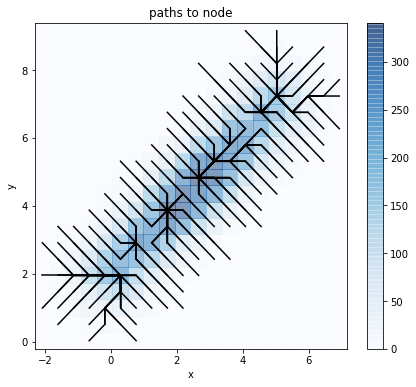

In [21]:
subplot = canvas(1, 1, 6, 7)

subplot(1)
plt.hist2d(*cells, bins = bins, weights = enes, alpha = 0.5)
paths     = [clouds.get_path(kid, epath)      for kid in kids]
segments  = [clouds.get_segment(cells, path) for path in paths]
for segment in segments:
    plt.plot(*segment, c = 'black');
plt.xlabel('x'); plt.ylabel('y'); plt.title('paths to node')
plt.colorbar();

## 2. Passes

   * Define the divergent region
   
   * Calculate the borders between nodes
   
   * Calculate the gradiant of the border cells to the other node
   
   * Select the pass with the highest pass in the divergent region.


### Define the convex region

  * Compute the laplacian and select the region with negative laplacian (dispersive region)

In [23]:
#cells_selection_ = pltclouds.cell_selection
laplacian   = clouds.laplacian(bins, mask, cells, enes)
cutoff      = np.percentile(laplacian, 25.)
cutoff      = min(0., cutoff)
print(cutoff)
isdivergent = laplacian < cutoff

-29.15301890432099


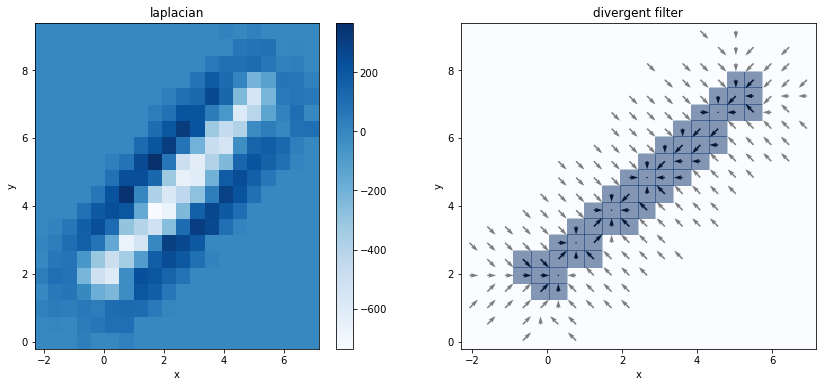

In [25]:
subplot = canvas(1, 2, 6, 7)
subplot(1)
plt.hist2d(*cells, bins = bins, weights = laplacian)
plt.xlabel('x'); plt.ylabel('y'); plt.title('laplacian')
plt.colorbar();

subplot(2)
pltclouds.draw_grad(cells, epath);
plt.hist2d(*cells, bins, weights = isdivergent, alpha = 0.5)
plt.xlabel('x'); plt.ylabel('y'); plt.title('divergent filter');

### Identify the cells in the border 

   * *lgrand*: The potential of this cell plus the potencial on the neighbour cell of the connected node with the largest potential 
   
   * *lnode*: The ID of the connected node of the other region to which this cell is a border cell
   
   * *lpath*: The ID of the neighbour cell with the largest potential on the connected region.

In [26]:
isborder  = clouds.find_borders(bins, mask, cells, node)

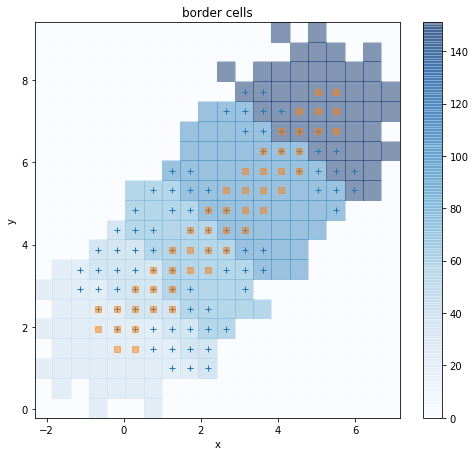

In [28]:
subplot = canvas(2, 2, 8, 9)

subplot(1)
plt.hist2d(*cells, bins, weights = node  , alpha = 0.5);
plt.colorbar();
plt.plot(*cells_selection(cells, isborder)   , marker = '+', ls = '');
plt.plot(*cells_selection(cells, isdivergent), marker = 's', ls = '', alpha = 0.5);
plt.xlabel('x'); plt.ylabel('y'); plt.title('border cells');

In [29]:
lgrad, lpath = clouds.gradient_between_nodes(bins, mask, cells, enes, node, isborder,
                                             absolute = True)

Text(0.5, 1.0, 'links')

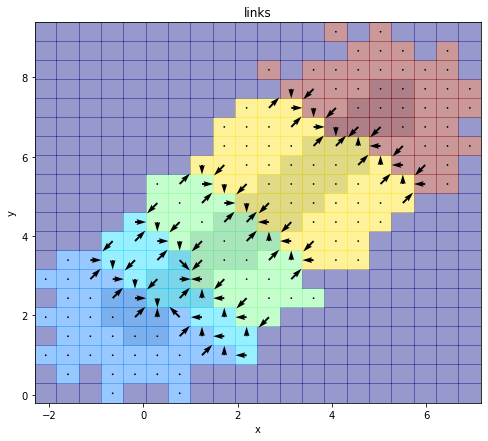

In [30]:
canvas(1, 1, 7, 8)
plt.hist2d(*cells, bins, weights = isdivergent, alpha = 0.2);
plt.hist2d(*cells, bins, weights = node       , alpha = 0.4, cmap = 'jet');
pltclouds.draw_grad(cells, lpath)
#plt.hist2d(*cells, bins, weights = lgrad      , alpha = 0.4);
#plt.hist2d(*csel_(cells, cells_border), bins, weights = cells_lpath[cells_border]);
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'links')

## 3. Selecting the passes

   * Select a pass:
   
      * cells with oposite gradient in the borders
  
      * cells in oposite node regions
      
      * dispersive cells (negative laplacian)
  

In [31]:
ispass = clouds.find_passes(node, lpath, lgrad, isdivergent)
print('number of cells passes', int(np.sum(ispass)/2))

number of cells passes 4


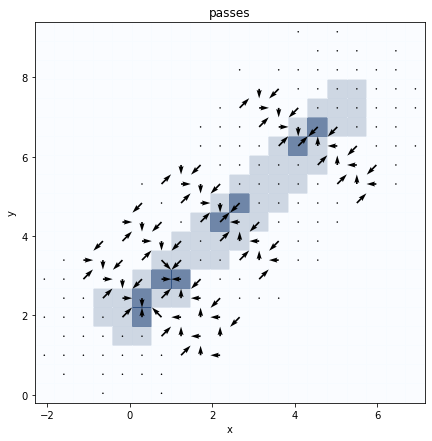

In [33]:
canvas(1, 1, 7, 7)
#plt.hist2d(*cells, bins, weights = isborder  , alpha = 0.3);
plt.hist2d(*cells, bins, weights = isdivergent, alpha = 0.3)
plt.hist2d(*cells, bins, weights = ispass     , alpha = 0.4)
pltclouds.draw_grad(cells, lpath)
plt.xlabel('x'); plt.ylabel('y'); plt.title(r'passes');

## Ridges

In [47]:
print(epath == kids)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False Fa

In [49]:
print(np.argwhere(ridge))

[[ 37]
 [ 38]
 [ 51]
 [ 61]
 [ 73]
 [ 74]
 [ 88]
 [101]
 [114]
 [126]
 [138]
 [151]]


In [50]:
ridges  = clouds.get_new_ridges(ispass, epath, lpath)
ridge   = clouds.find_new_ridge (ispass, epath, lpath)
eridge  = clouds.energy_in_ridge(enes, ridge, epath)

kid  0 path  [0, 5, 12, 20, 28, 37]
kid  0 path  [0, 5, 12, 20, 28, 37] jid 37 enes  1.0
kid  1 path  [1, 6, 12, 20, 28, 37]
kid  1 path  [1, 6, 12, 20, 28, 37] jid 37 enes  2.0
kid  2 path  [2, 7, 12, 20, 28, 37]
kid  2 path  [2, 7, 12, 20, 28, 37] jid 37 enes  3.0
kid  3 path  [3, 10, 19, 28, 37]
kid  3 path  [3, 10, 19, 28, 37] jid 37 enes  4.0
kid  4 path  [4, 11, 20, 28, 37]
kid  4 path  [4, 11, 20, 28, 37] jid 37 enes  5.0
kid  5 path  [5, 12, 20, 28, 37]
kid  5 path  [5, 12, 20, 28, 37] jid 37 enes  9.0
kid  6 path  [6, 12, 20, 28, 37]
kid  6 path  [6, 12, 20, 28, 37] jid 37 enes  20.0
kid  7 path  [7, 12, 20, 28, 37]
kid  7 path  [7, 12, 20, 28, 37] jid 37 enes  29.0
kid  8 path  [8, 13, 20, 28, 37]
kid  8 path  [8, 13, 20, 28, 37] jid 37 enes  34.0
kid  9 path  [9, 14, 21, 28, 37]
kid  9 path  [9, 14, 21, 28, 37] jid 37 enes  35.0
kid  10 path  [10, 19, 28, 37]
kid  10 path  [10, 19, 28, 37] jid 37 enes  49.0
kid  11 path  [11, 20, 28, 37]
kid  11 path  [11, 20, 28, 37] jid 37

kid  188 path  [188, 180, 171, 162, 151]
kid  188 path  [188, 180, 171, 162, 151] jid 151 enes  2292.0
kid  189 path  [189, 181, 172, 162, 151]
kid  189 path  [189, 181, 172, 162, 151] jid 151 enes  2293.0
kid  190 path  [190, 182, 173, 162, 151]
kid  190 path  [190, 182, 173, 162, 151] jid 151 enes  2294.0
kid  191 path  [191, 186, 180, 171, 162, 151]
kid  191 path  [191, 186, 180, 171, 162, 151] jid 151 enes  2295.0
kid  192 path  [192, 187, 180, 171, 162, 151]
kid  192 path  [192, 187, 180, 171, 162, 151] jid 151 enes  2299.0
kid  193 path  [193, 187, 180, 171, 162, 151]
kid  193 path  [193, 187, 180, 171, 162, 151] jid 151 enes  2300.0


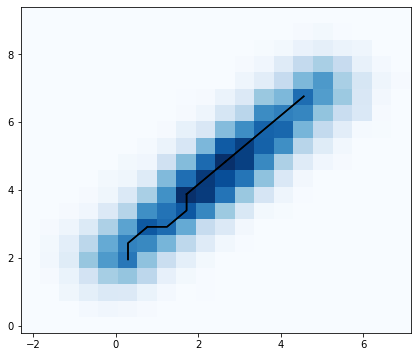

In [51]:
canvas(1, 1, 6, 7)

plt.hist2d(*cells, bins, weights = enes, alpha = 1.)
#plt.colorbar();
for path in ridges:
    segment = clouds.get_segment(cells, path)
    plt.plot(*segment, ls = '-', c = 'black' )

In [52]:
print('ridge energy ', np.sum(eridge), 'total energy', np.sum(enes))

ridge energy  16000.0 total energy 16000.0
